In [7]:
import pandas as pd
import numpy as np  
import re
from html import unescape
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

def show(df, n=5):
    display(df.head(n))

In [8]:
path = "dataset/Reviews_Dataset.csv"
df = pd.read_csv(path, low_memory=False)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
show(df, 6)

Shape: (40432, 4)
Columns: ['category', 'rating', 'label', 'text_']


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...
5,Home_and_Kitchen_5,3.0,CG,I WANTED DIFFERENT FLAVORS BUT THEY ARE NOT.


Shape of dataset: (40432, 4)
Null Values: category    0
rating      0
label       0
text_       0
dtype: int64
Unique cats: 10
Unique labels: ['CG' 'OR']


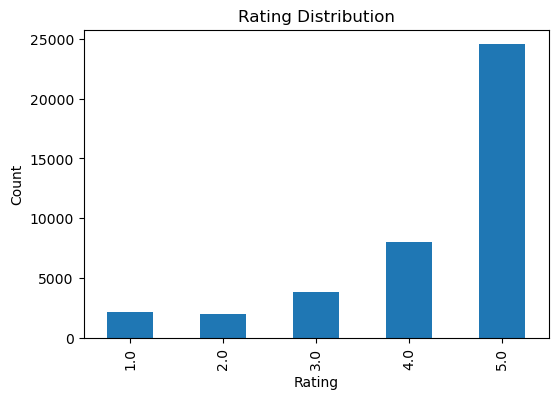

In [9]:
print("Shape of dataset:", df.shape)
print("Null Values:", df.isnull().sum())

print("Unique cats:", df['category'].nunique())
print("Unique labels:", df['label'].unique())

plt.figure(figsize=(6,4))
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [10]:
def clean_text(text):
    text = text.lower() #lowercase
    text = unescape(text)   #decoding html
    text = re.sub(r"http\S+|www\S+", "", text)  #removes all links  
    text = re.sub(r"[^a-z\s]", "", text)    #keeps only alphabets
    text = re.sub(r"\s+", " ", text).strip()    #remove extra spaces
    return text

df['clean_text'] = df['text_'].apply(clean_text)
show(df[['text_', 'clean_text']], 5)

,text_,clean_text
0,"Love this! Well made, sturdy, and very comfor...",love this well made sturdy and very comfortabl...
1,"love it, a great upgrade from the original. I...",love it a great upgrade from the original ive ...
2,This pillow saved my back. I love the look and...,this pillow saved my back i love the look and ...
3,"Missing information on how to use it, but it i...",missing information on how to use it but it is...
4,Very nice set. Good quality. We have had the s...,very nice set good quality we have had the set...


In [11]:
print(df.isnull().sum())
df.head()

category      0
rating        0
label         0
text_         0
clean_text    0
dtype: int64


,category,rating,label,text_,clean_text
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",love this well made sturdy and very comfortabl...
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",love it a great upgrade from the original ive ...
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,this pillow saved my back i love the look and ...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",missing information on how to use it but it is...
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,very nice set good quality we have had the set...


In [12]:
from sklearn.model_selection import train_test_split

X = df[['clean_text', 'rating', 'category']]
Y = df['label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

rf_pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=2)),
    ("rf", RandomForestClassifier(
        n_estimators=400, max_depth=None, max_features="sqrt", n_jobs=-1, random_state=42
    ))
])

rf_pipe.fit(X_train_text, y_train)
y_pred = rf_pipe.predict(X_test_text)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9072585631260047
[[3558  486]
 [ 264 3779]]
              precision    recall  f1-score   support

          CG       0.93      0.88      0.90      4044
          OR       0.89      0.93      0.91      4043

    accuracy                           0.91      8087
   macro avg       0.91      0.91      0.91      8087
weighted avg       0.91      0.91      0.91      8087



In [ ]:
import numpy as np, re
from html import unescape
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

X_tr_txt, X_te_txt, y_tr, y_te = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=30000, min_df=2, sublinear_tf=True)
Xtr = tfidf.fit_transform(X_tr_txt)
Xte = tfidf.transform(X_te_txt)

best_C, best_f1 = None, -1
for C in [0.5, 1.0, 2.0, 4.0]:
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1s = []
    for tr, va in skf.split(Xtr, y_tr):
        m = LinearSVC(C=C, class_weight='balanced', random_state=42)
        m.fit(Xtr[tr], y_tr.iloc[tr])
        pred = m.predict(Xtr[va])
        f1s.append(f1_score(y_tr.iloc[va], pred, average='macro'))
    if np.mean(f1s) > best_f1: best_f1, best_C = np.mean(f1s), C

svc = LinearSVC(C=best_C, class_weight='balanced', random_state=42)
svc.fit(Xtr, y_tr)
yp = svc.predict(Xte)

print("Best C:", best_C, "CV macroF1≈", round(best_f1,4))
print("Accuracy:", accuracy_score(y_te, yp))
print(confusion_matrix(y_te, yp))
print(classification_report(y_te, yp))


Best C: 1.0 CV macroF1≈ 0.9438
Accuracy: 0.9448497588722641
[[3807  237]
 [ 209 3834]]
              precision    recall  f1-score   support

          CG       0.95      0.94      0.94      4044
          OR       0.94      0.95      0.95      4043

    accuracy                           0.94      8087
   macro avg       0.94      0.94      0.94      8087
weighted avg       0.94      0.94      0.94      8087

